In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [27]:
smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"

dataset_bank_tns_df = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_{smote_suffix}.csv.gz', compression='gzip', index_col='ztf_object_id')
dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,0.630460,1.074418,0.400000,0.000000,0.457814,1.260920,1.047050,0.832848,-1.744178,0.027233,...,-0.096199,-0.062302,-0.075001,-0.101900,14.188714,2.588904,Yes_TNS,None,-99.00000,ZTF
ZTF21aarzxnb,0.121910,0.562210,0.142857,0.000000,0.376162,0.243820,0.218541,0.099431,1.578408,0.012642,...,0.172100,0.201801,-0.015202,-0.012701,0.801429,0.175727,Yes_TNS,None,-99.00000,ALeRCE
ZTF18acsxjhc,0.926579,1.119445,0.303797,0.037975,0.349061,1.801871,1.069640,0.539695,-0.012415,0.001636,...,0.748601,0.825200,0.762100,0.754800,42.918356,0.008771,Yes_TNS,None,-99.00000,iPTF


In [3]:
with open(f'../loci_dbs/alerce_cut/dataset_label_orig_{smote_suffix}.pkl', 'rb') as f:
    dataset_label_orig = pickle.load(f)

In [9]:
dataset_label_orig

['None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN II',
 'SN Ib',
 'SN Ib',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN II',
 'None',
 'None',
 'SN II',
 'SN Ia',
 'None',
 'None',
 'SN II',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'SN IIP',
 'SN Ia',
 'None',
 'SN Ib',
 'SN Ia',
 'SN Ia',
 'None',
 'None',
 'SN II',
 'None',
 'None',
 'SN Ia',
 'SN II',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'SN Ia',
 'None',
 'None',
 'SN Ia',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'SN Ia',
 'SN II',
 'None',
 'None',
 'None',
 'None',
 'SN Ib',
 'None',
 'None',
 'None',
 'None',
 'SN Ia',
 'None',
 'None',
 'None',
 'N

In [4]:
smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

In [5]:
dataset_bank_tns_df_resampled_train

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc28309,0.648056,0.438369,0.306405,0.000000,0.350863,1.296113,1.132292,0.416165,2.372943,-0.013326,...,0.502309,0.721143,0.811645,0.579434,39.665981,0.019535,Fake,TDE,-99.00000,None
ZTFabc68180,0.486110,0.605627,0.258561,0.017279,0.317578,0.937265,0.604629,0.378644,0.566701,-0.007330,...,-0.059388,-0.053494,-0.067460,-0.116639,8.221067,0.055221,Fake,TDE,-99.00000,None
ZTFabc68264,0.447717,0.433476,0.428571,0.000000,0.403265,0.895435,0.820801,0.547785,-0.871551,0.005264,...,0.466027,0.127562,0.206142,0.121683,2.985047,0.021310,Fake,TDE,-99.00000,None


In [6]:
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.429100,0.487600,0.394600,0.479000,17.508340,0.363381,Yes_TNS,SN Ia,0.076000,ALeRCE
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,1.987599,2.187201,1.923100,1.677900,127.987642,1.280643,Yes_TNS,SN Ic-BL,0.023563,ZTF
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.537500,0.461899,0.366699,0.308001,73.202796,0.245163,Yes_TNS,SN Ia,0.048167,ZTF
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,1.203501,1.442598,1.337000,1.170200,29.489402,0.282454,Yes_TNS,SN Ia,0.041000,ALeRCE
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.024799,-0.047600,0.003399,-0.067900,37.216605,4.749794,Yes_TNS,SN Ia,0.070000,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.869000,1.001200,1.090099,1.092001,48.668157,0.124452,Yes_TNS,SN Ia-91T-like,0.037437,ALeRCE
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.387199,0.329800,0.383400,0.422300,58.550706,0.012833,Yes_TNS,SN Ia,0.097780,AMPEL
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,1.349999,1.271399,1.157599,1.225500,124.418488,0.916609,Yes_TNS,SN Ia,0.040000,ALeRCE


In [84]:
n_estimators=3500
max_depth=35 
random_state=10

In [57]:
%%time
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
clf.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

CPU times: user 17min 41s, sys: 3.22 s, total: 17min 45s
Wall time: 17min 49s


RandomForestClassifier(max_depth=35, n_estimators=3500, random_state=10)

In [85]:
pickle.dump(clf, open(f'../pickles/RFC_model_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}.pkl', 'wb'))

### Load pickle

In [87]:
with open(f'../pickles/RFC_model_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}.pkl', 'rb') as f:
    clf = pickle.load(f)

In [58]:
# Predict Excluded Object
predicted_probability = 100 * clf.predict_proba(dataset_bank_tns_df_resampled_test.iloc[:, 0:120])

In [59]:
clf.classes_

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [60]:
# Predicted Probability to be ['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
#                              'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE']
predicted_probability

array([[22.74285714,  0.31428571,  2.54285714, ...,  0.08571429,
         0.42857143,  7.02840425],
       [ 5.54285714,  0.        , 38.31474321, ..., 12.51369216,
         0.77142857,  0.68571429],
       [38.05714286,  1.8       , 16.94285714, ...,  0.28571429,
         0.54285714,  7.82857143],
       ...,
       [ 1.94285714,  0.2       ,  5.62857143, ...,  1.62857143,
         0.22857143,  0.54285714],
       [ 6.65714286,  0.        , 21.68573703, ...,  8.82852593,
         0.51428571,  0.11428571],
       [ 9.97142857,  0.17142857,  5.14285714, ...,  0.45714286,
         1.42857143,  4.74297007]])

In [97]:
clf.classes_[1:]

array(['SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [62]:
predicted_probability.shape

(455, 12)

In [103]:
# Create a dataframe from the arrays
df = pd.DataFrame(predicted_probability, columns=clf.classes_)
df = df.set_index(dataset_bank_tns_df_resampled_test.index)

# Add a new column "RFC_best_cls" to the existing dataframe that contains the class label with the highest probability per row
# clf.classes_[1:] and row.values[1:] ignores the None class
df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[1:][np.argmax(row.values[1:])], axis=1)
df

,None,SLSN-II,SN II,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,
ZTF21aazebgh,22.742857,0.314286,2.542857,0.114286,0.914286,0.771709,61.142744,2.171429,1.742857,0.085714,0.428571,7.028404,SN Ia
ZTF21acgxypn,5.542857,0.000000,38.314743,5.485714,7.171469,3.057143,9.771504,0.742857,15.942877,12.513692,0.771429,0.685714,SN II
ZTF19aapqqrb,38.057143,1.800000,16.942857,1.028571,0.171429,2.057143,23.657143,6.600000,1.028571,0.285714,0.542857,7.828571,SN Ia
ZTF21aasbxng,3.000000,0.000000,20.600000,0.257143,2.628571,2.542857,56.114286,5.285714,1.600000,2.942857,4.371429,0.657143,SN Ia
ZTF21aaglgcb,28.971429,5.857143,11.200000,0.028571,0.714286,6.085714,27.428571,10.457143,0.914286,0.114286,0.600000,7.628571,SN Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,2.828571,0.028571,10.971429,0.114286,7.428571,3.342857,61.828571,7.342857,0.800000,2.057143,1.485714,1.771429,SN Ia
ZTF21abdcauj,19.457143,0.314286,2.142857,0.000000,0.514286,0.885714,55.228766,9.856948,0.657143,0.085714,1.314286,9.542857,SN Ia
ZTF21aaetnfe,1.942857,0.200000,5.628571,0.028571,3.914286,1.828571,83.171429,0.571429,0.314286,1.628571,0.228571,0.542857,SN Ia


In [104]:
df2 = pd.concat([dataset_bank_tns_df_resampled_test, df], axis=1)
df2

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.114286,0.914286,0.771709,61.142744,2.171429,1.742857,0.085714,0.428571,7.028404,SN Ia
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,5.485714,7.171469,3.057143,9.771504,0.742857,15.942877,12.513692,0.771429,0.685714,SN II
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,1.028571,0.171429,2.057143,23.657143,6.600000,1.028571,0.285714,0.542857,7.828571,SN Ia
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.257143,2.628571,2.542857,56.114286,5.285714,1.600000,2.942857,4.371429,0.657143,SN Ia
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.028571,0.714286,6.085714,27.428571,10.457143,0.914286,0.114286,0.600000,7.628571,SN Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.114286,7.428571,3.342857,61.828571,7.342857,0.800000,2.057143,1.485714,1.771429,SN Ia
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.000000,0.514286,0.885714,55.228766,9.856948,0.657143,0.085714,1.314286,9.542857,SN Ia
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,0.028571,3.914286,1.828571,83.171429,0.571429,0.314286,1.628571,0.228571,0.542857,SN Ia


In [105]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(20, 14)):
    if kind == 'completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18})
    plt.title(title, fontsize=24)
    plt.ylabel('True class', fontsize=24)
    plt.xlabel('Predicted class', fontsize=24)
    #plt.show()

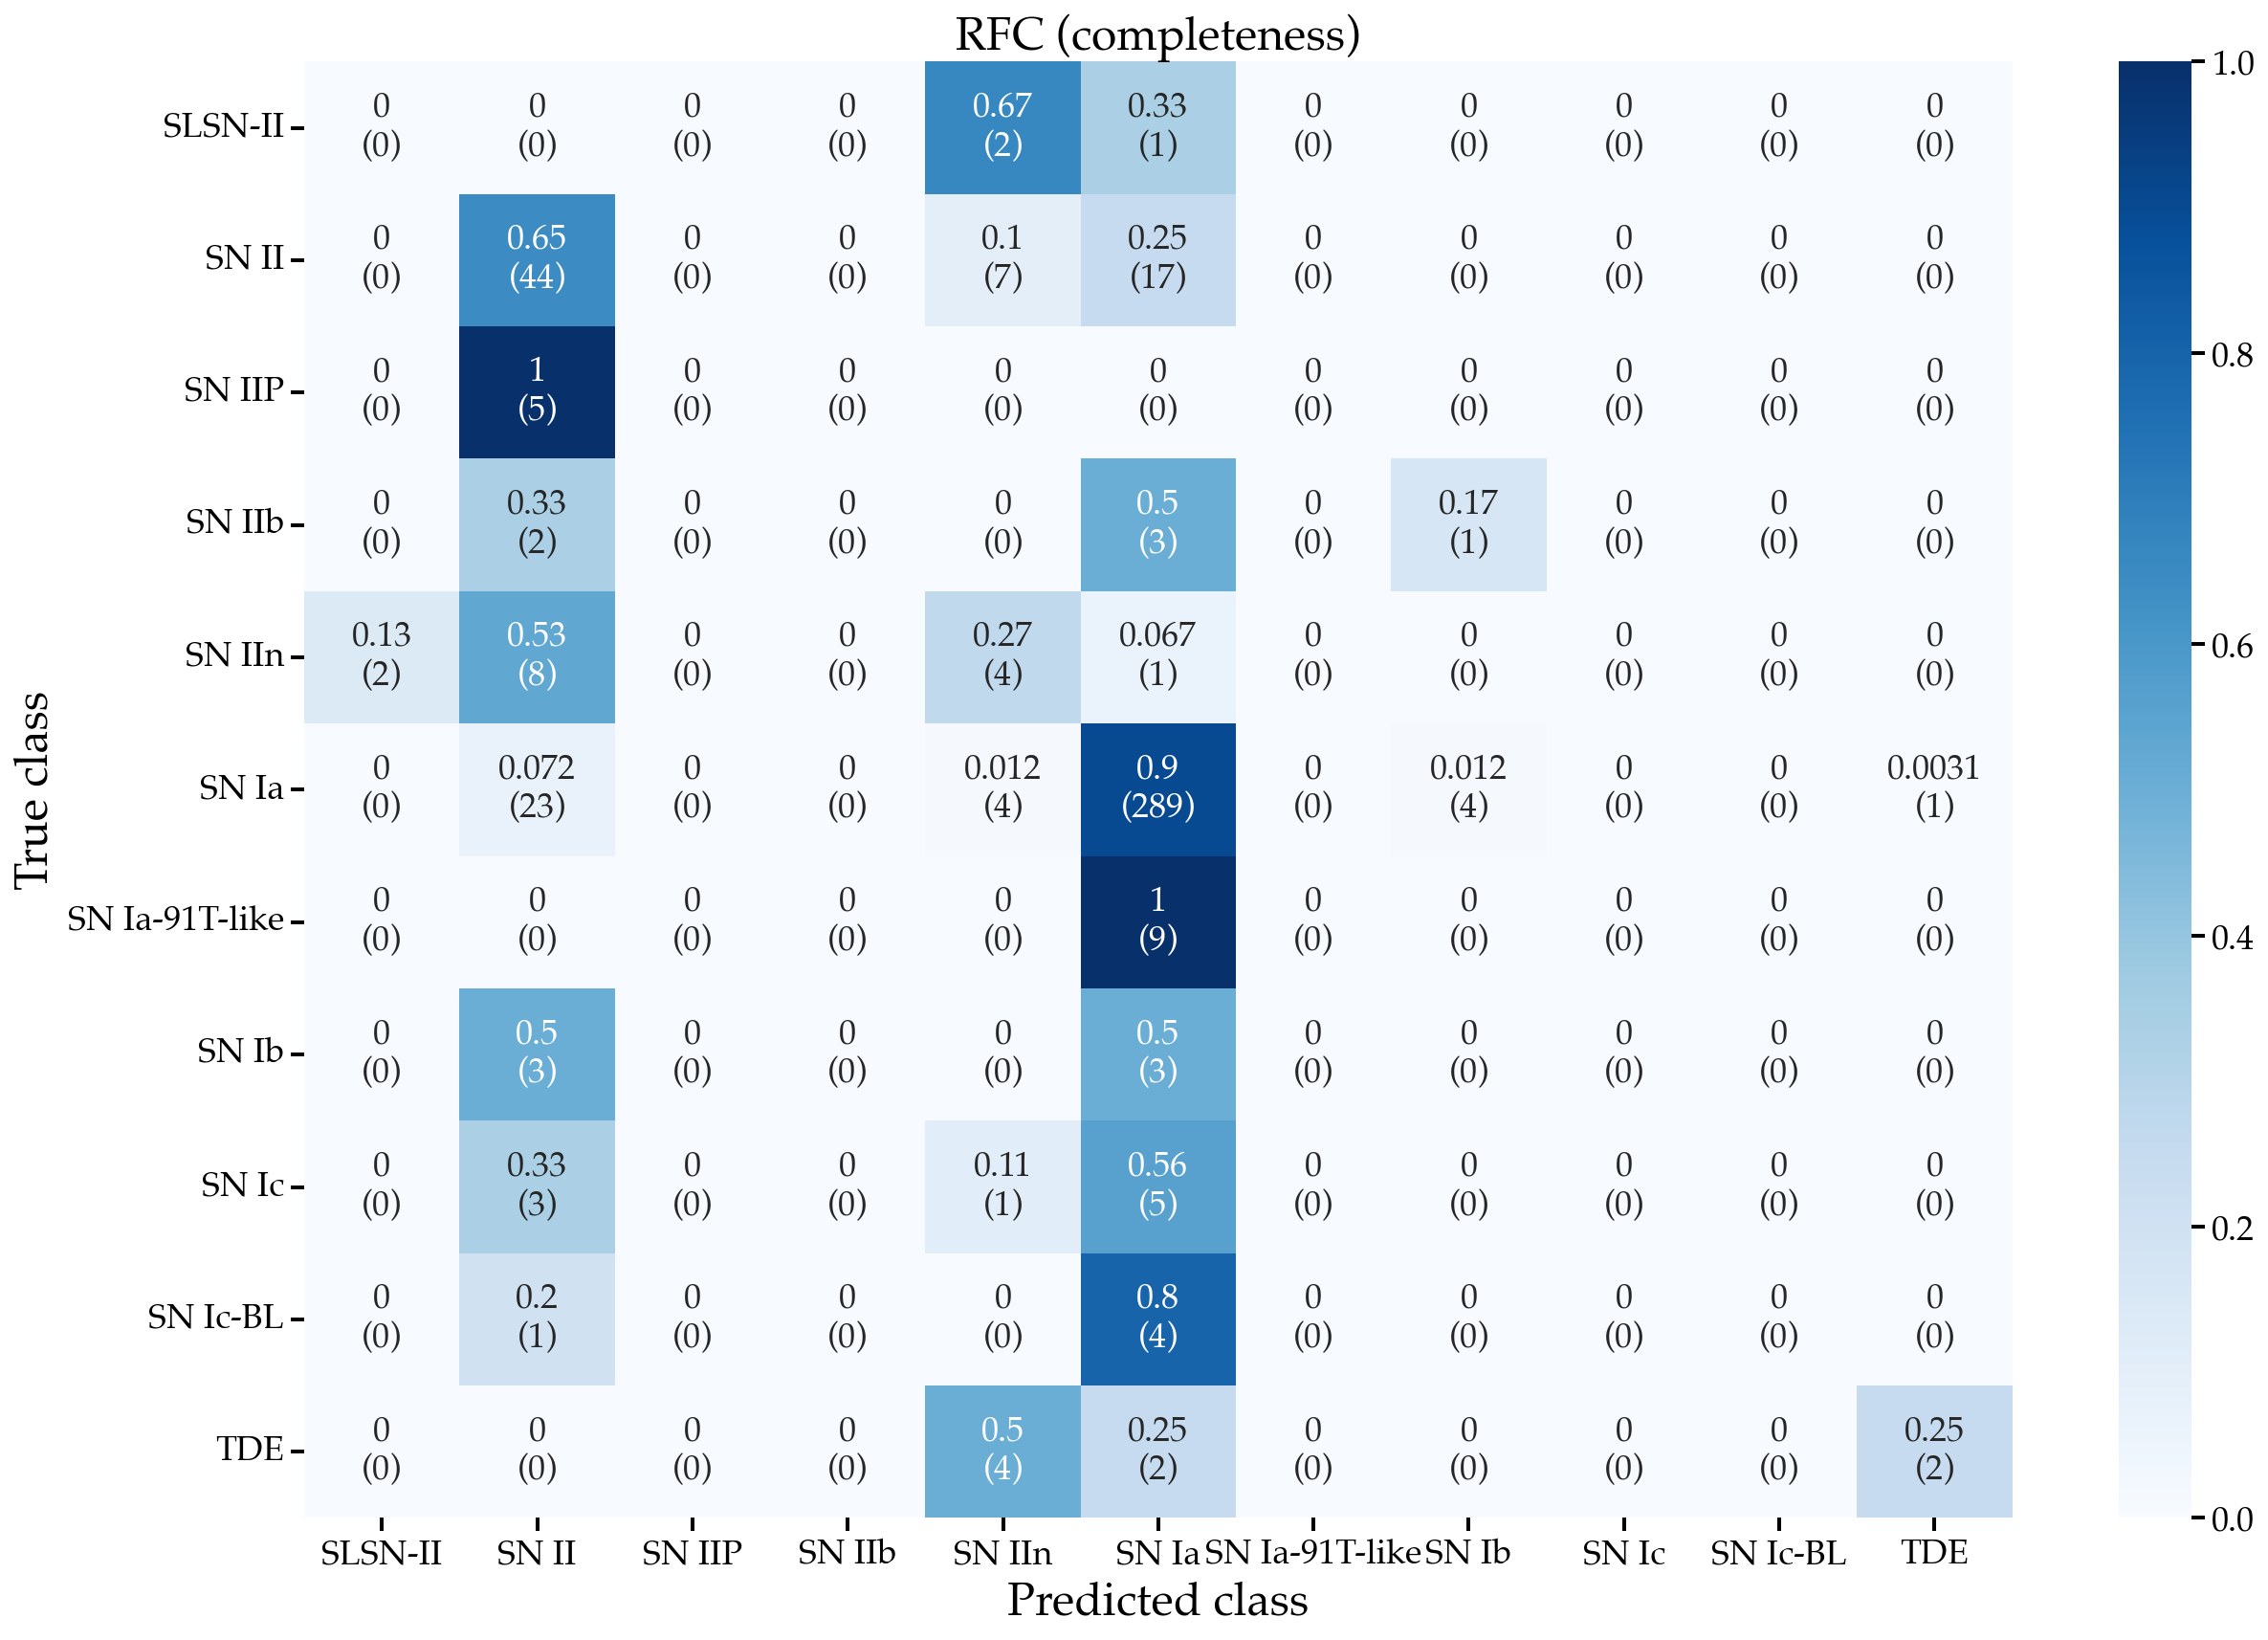

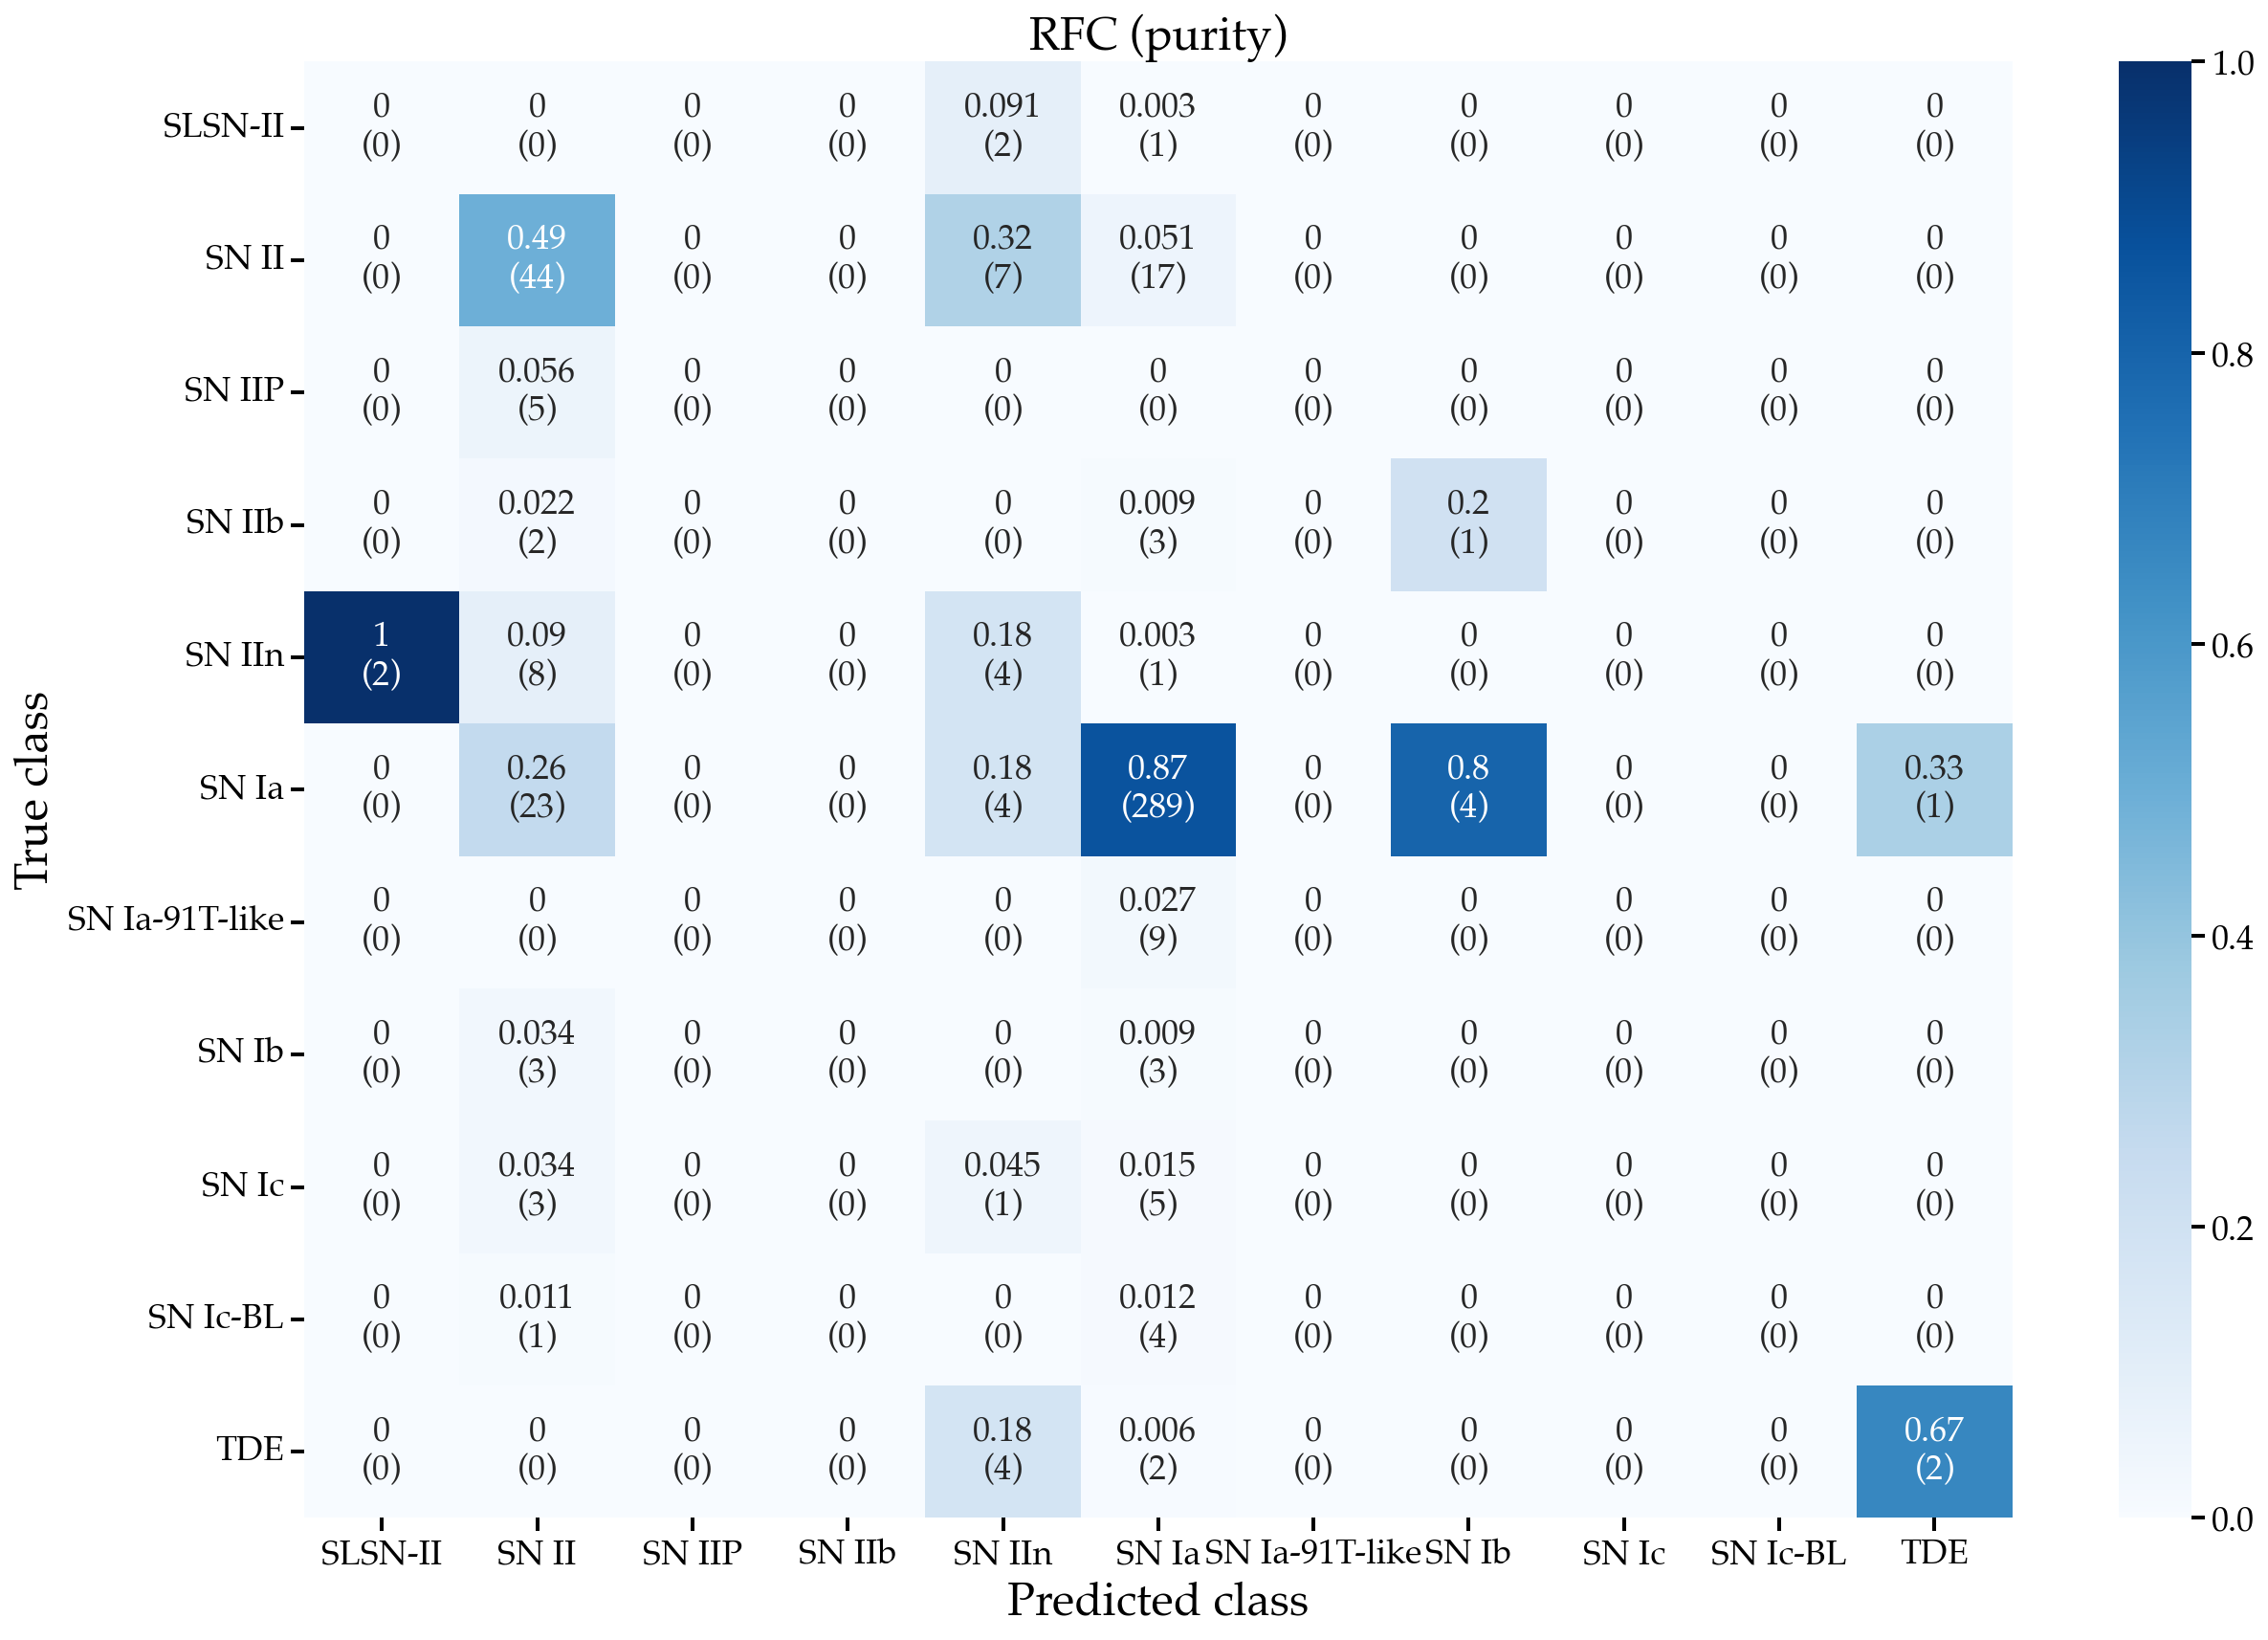

In [126]:
# Confusion matrices
title='RFC'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

folder_path = f"../figures/confusion_matrix/{suffix}/n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [127]:
sim_class_di = {'CV': 'CV', 
      'SLSN-I': 'SLSN', 
      'SLSN-II': 'SLSN', 
      'SN II': 'SN II', 
      'SN IIP': 'SN II', 
      'SN IIb': 'SN II', 
      'SN IIn': 'SN II',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN Ibc', 
      'SN Ib/c': 'SN Ibc',
      'SN Ibn': 'SN Ibc', 
      'SN Ic': 'SN Ibc',
      'SN Ic-BL': 'SN Ibc', 
      'TDE': 'TDE',
      'None': 'None',
      'SN': 'SN',
      'SN I': 'SN I',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_sim_class = df2.copy()
ann0_ann1_df_noNone_sim_class['tns_cls'] = ann0_ann1_df_noNone_sim_class['tns_cls'].map(sim_class_di)
ann0_ann1_df_noNone_sim_class['RFC_best_cls'] = ann0_ann1_df_noNone_sim_class['RFC_best_cls'].map(sim_class_di)
#ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'].map(sim_class_di)

In [128]:
ann0_ann1_df_noNone_sim_class

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.114286,0.914286,0.771709,61.142744,2.171429,1.742857,0.085714,0.428571,7.028404,SN Ia
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,5.485714,7.171469,3.057143,9.771504,0.742857,15.942877,12.513692,0.771429,0.685714,SN II
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,1.028571,0.171429,2.057143,23.657143,6.600000,1.028571,0.285714,0.542857,7.828571,SN Ia
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.257143,2.628571,2.542857,56.114286,5.285714,1.600000,2.942857,4.371429,0.657143,SN Ia
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.028571,0.714286,6.085714,27.428571,10.457143,0.914286,0.114286,0.600000,7.628571,SN Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.114286,7.428571,3.342857,61.828571,7.342857,0.800000,2.057143,1.485714,1.771429,SN Ia
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.000000,0.514286,0.885714,55.228766,9.856948,0.657143,0.085714,1.314286,9.542857,SN Ia
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,0.028571,3.914286,1.828571,83.171429,0.571429,0.314286,1.628571,0.228571,0.542857,SN Ia


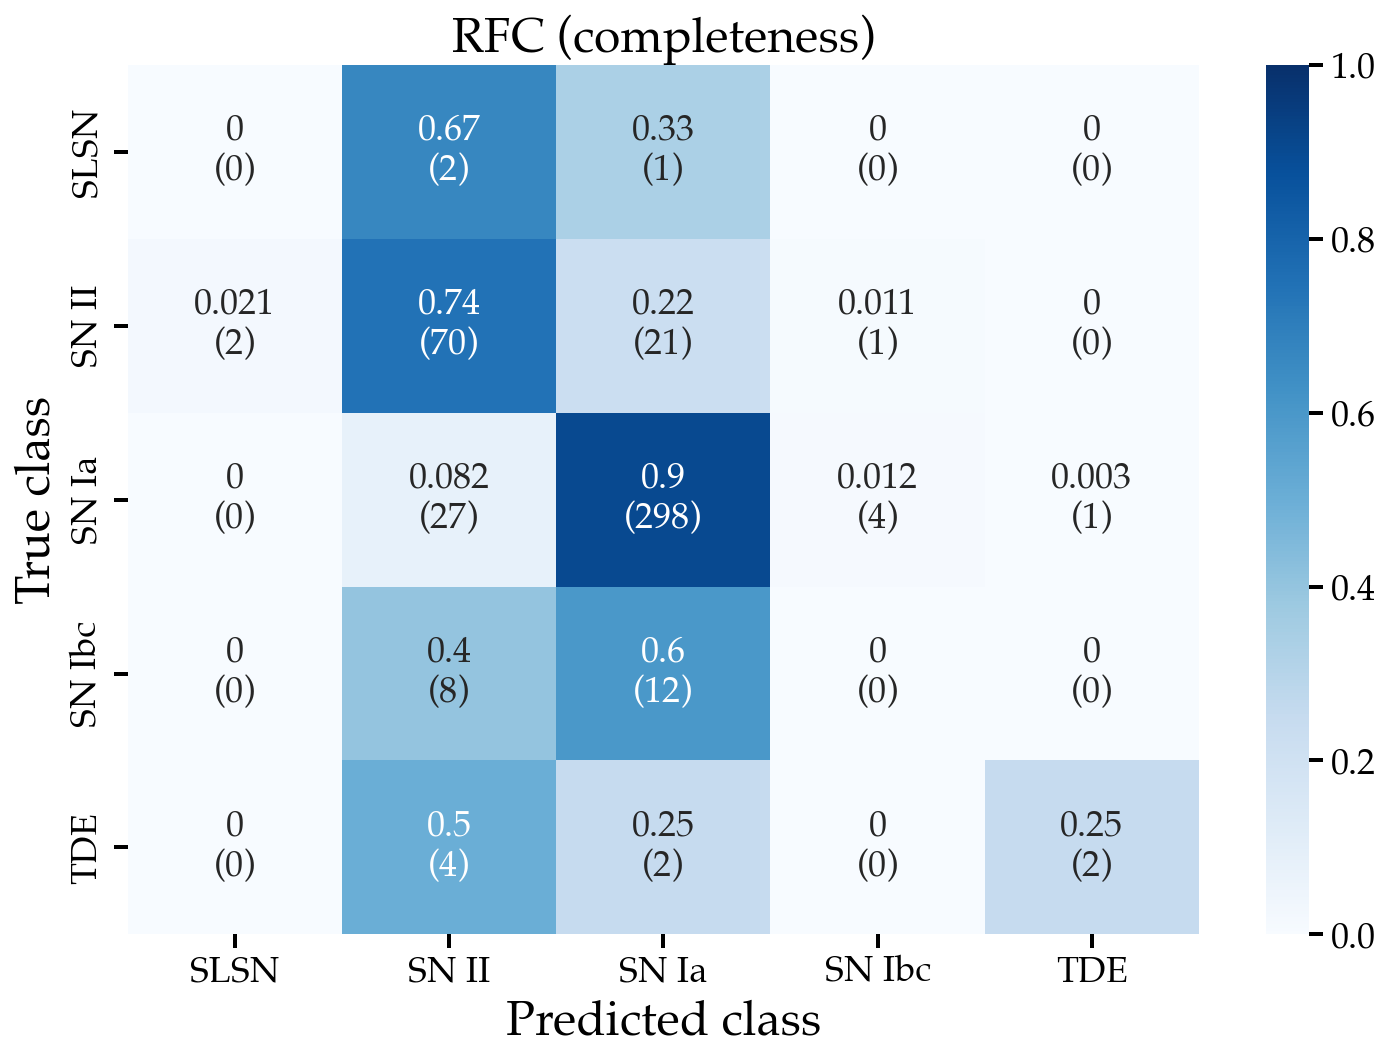

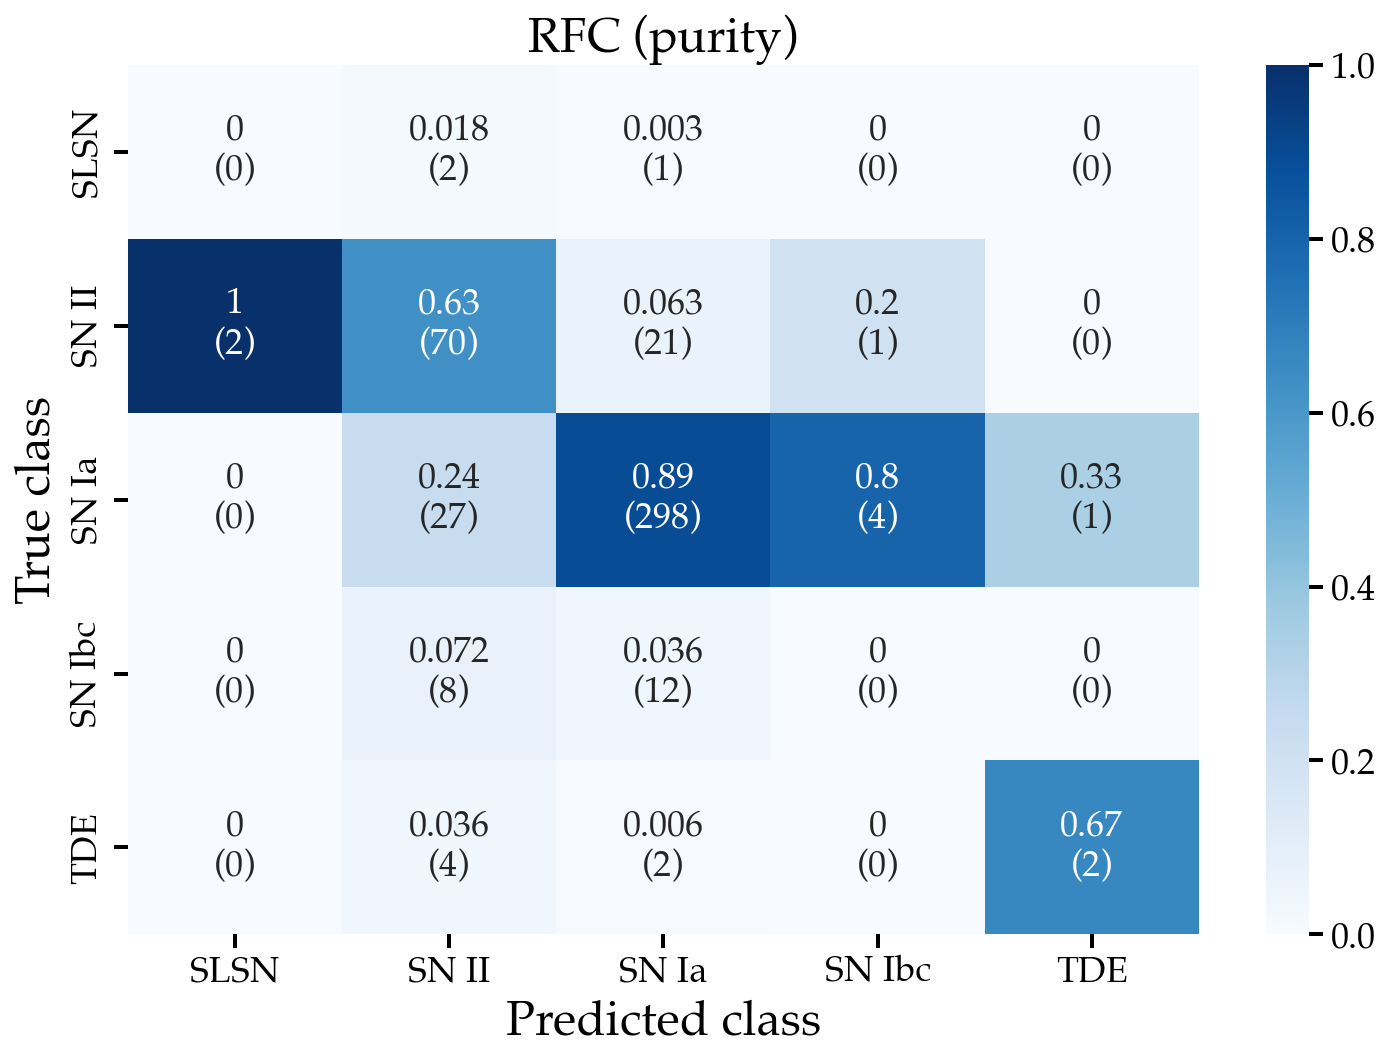

In [129]:
# Confusion matrices
df = ann0_ann1_df_noNone_sim_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(12, 8))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_similar_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [130]:
### CC vs Ia vs Exotic (TDE, SLSN)

bin_class_di = {'CV': 'CV', 
      'SLSN-I': 'Exotic', 
      'SLSN-II': 'Exotic', 
      'SN II': 'SN CC', 
      'SN IIP': 'SN CC', 
      'SN IIb': 'SN CC', 
      'SN IIn': 'SN CC',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN CC', 
      'SN Ib/c': 'SN CC',
      'SN Ibn': 'SN CC', 
      'SN Ic': 'SN CC',
      'SN Ic-BL': 'SN CC', 
      'TDE': 'Exotic',
      'None': 'None',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_bin_class = df2.copy()
ann0_ann1_df_noNone_bin_class['tns_cls'] = ann0_ann1_df_noNone_bin_class['tns_cls'].map(bin_class_di)
ann0_ann1_df_noNone_bin_class['RFC_best_cls'] = ann0_ann1_df_noNone_bin_class['RFC_best_cls'].map(bin_class_di)
#ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'].map(bin_class_di)

In [131]:
mask = (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'AGN') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'CV') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_bin_class = ann0_ann1_df_noNone_bin_class[mask]
ann0_ann1_df_noNone_bin_class

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.114286,0.914286,0.771709,61.142744,2.171429,1.742857,0.085714,0.428571,7.028404,SN Ia
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,5.485714,7.171469,3.057143,9.771504,0.742857,15.942877,12.513692,0.771429,0.685714,SN CC
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,1.028571,0.171429,2.057143,23.657143,6.600000,1.028571,0.285714,0.542857,7.828571,SN Ia
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.257143,2.628571,2.542857,56.114286,5.285714,1.600000,2.942857,4.371429,0.657143,SN Ia
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.028571,0.714286,6.085714,27.428571,10.457143,0.914286,0.114286,0.600000,7.628571,SN Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.114286,7.428571,3.342857,61.828571,7.342857,0.800000,2.057143,1.485714,1.771429,SN Ia
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.000000,0.514286,0.885714,55.228766,9.856948,0.657143,0.085714,1.314286,9.542857,SN Ia
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,0.028571,3.914286,1.828571,83.171429,0.571429,0.314286,1.628571,0.228571,0.542857,SN Ia


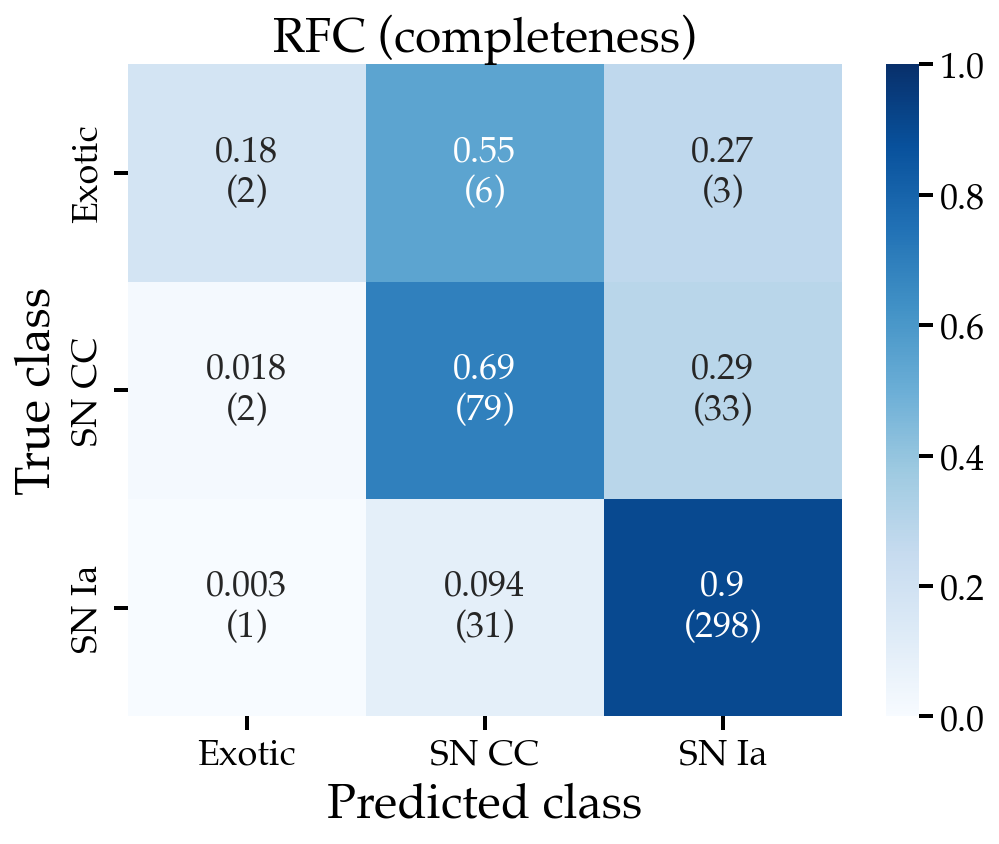

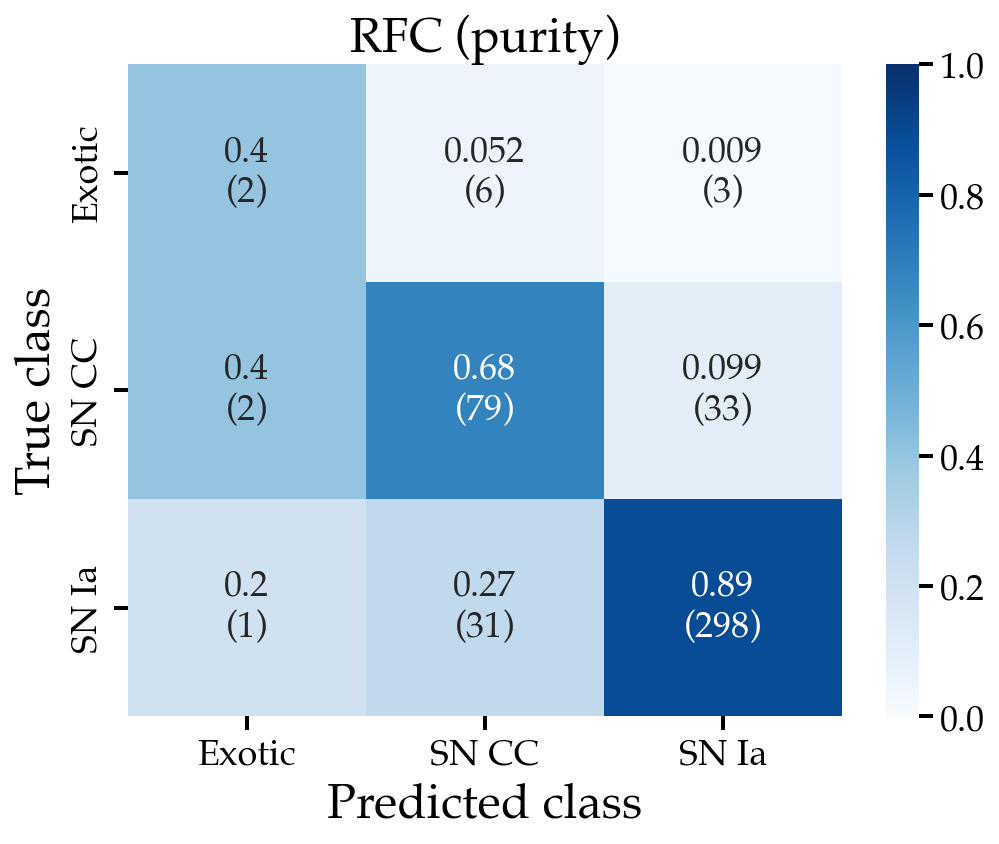

In [132]:
# Confusion matrices
df = ann0_ann1_df_noNone_bin_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(8, 6))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_binary_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [133]:
rare_v_not_class_di = {'CV': 'Not SN', 
      'SLSN-I': 'Rare', 
      'SLSN-II': 'Rare', 
      'SN II': 'Rare', 
      'SN IIP': 'Rare', 
      'SN IIb': 'Rare', 
      'SN IIn': 'Rare',
      'SN Ia': 'NOT Rare', 
      'SN Ia-91T-like': 'Rare', 
      'SN Ia-CSM': 'Rare',
      'SN Ia-91bg-like': 'Rare',
      'SN Ia-pec': 'Rare', 
      'SN Ib': 'Rare', 
      'SN Ib/c': 'Rare',
      'SN Ibn': 'Rare',
      'SN Ic': 'Rare',
      'SN Ic-BL': 'Rare', 
      'TDE': 'Rare',
      'None': 'NOT Rare',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'Not SN'}


ann0_ann1_df_noNone_rare_v_not_class = df2.copy()
ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] = ann0_ann1_df_noNone_rare_v_not_class['tns_cls'].map(rare_v_not_class_di)
ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'] = ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'].map(rare_v_not_class_di)
#ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'].map(rare_v_not_class_di)

In [134]:
mask = (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Not SN') & (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_rare_v_not_class = ann0_ann1_df_noNone_rare_v_not_class[mask]
ann0_ann1_df_noNone_rare_v_not_class

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.114286,0.914286,0.771709,61.142744,2.171429,1.742857,0.085714,0.428571,7.028404,NOT Rare
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,5.485714,7.171469,3.057143,9.771504,0.742857,15.942877,12.513692,0.771429,0.685714,Rare
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,1.028571,0.171429,2.057143,23.657143,6.600000,1.028571,0.285714,0.542857,7.828571,NOT Rare
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.257143,2.628571,2.542857,56.114286,5.285714,1.600000,2.942857,4.371429,0.657143,NOT Rare
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.028571,0.714286,6.085714,27.428571,10.457143,0.914286,0.114286,0.600000,7.628571,NOT Rare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,1.061692,0.242709,0.357143,0.071429,0.375832,2.123384,1.597695,0.657423,-0.115655,0.024840,...,0.114286,7.428571,3.342857,61.828571,7.342857,0.800000,2.057143,1.485714,1.771429,NOT Rare
ZTF21abdcauj,0.633349,0.322944,0.400000,0.000000,0.419177,1.266699,0.828672,0.586951,-0.800553,0.020024,...,0.000000,0.514286,0.885714,55.228766,9.856948,0.657143,0.085714,1.314286,9.542857,NOT Rare
ZTF21aaetnfe,1.442822,1.007647,0.380952,0.000000,0.455937,2.885643,2.600447,1.725258,-1.641959,0.034872,...,0.028571,3.914286,1.828571,83.171429,0.571429,0.314286,1.628571,0.228571,0.542857,NOT Rare


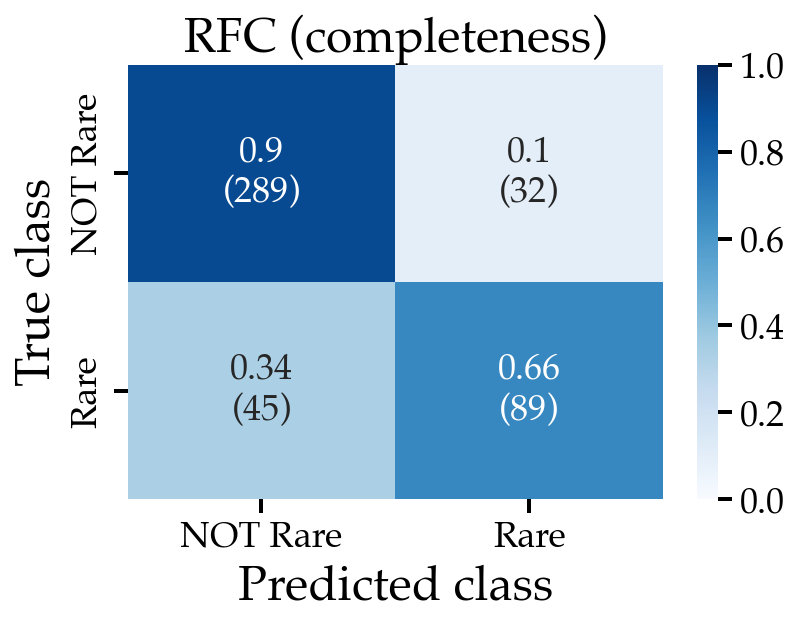

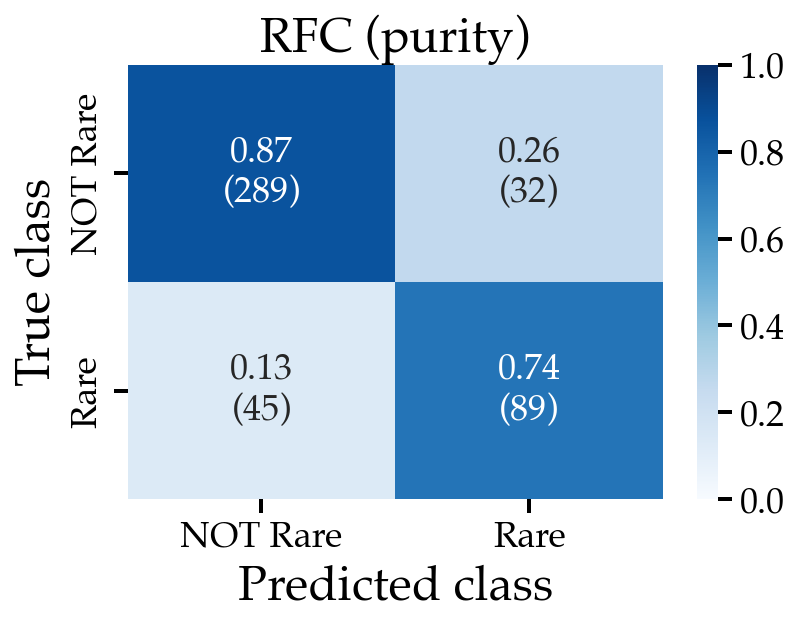

In [135]:
# Confusion matrices
df = ann0_ann1_df_noNone_rare_v_not_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls']) #np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(6, 4))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_rare_v_not_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [136]:
%%time 
# In summary, you train your Random Forest Classifier to classify your data, 
# and then use the Isolation Forest algorithm on the output probabilities of the Random Forest Classifier 
# to detect anomalies.

from sklearn.ensemble import IsolationForest

anomaly_scores = IsolationForest(n_estimators=500, random_state=10).fit(predicted_probability).decision_function(predicted_probability)

CPU times: user 767 ms, sys: 33.5 ms, total: 801 ms
Wall time: 651 ms


In [137]:
most_anomalous_indices = np.argsort(anomaly_scores)[:25]
most_anomalous_samples = df2.iloc[most_anomalous_indices]
most_anomalous_samples

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abgkfzh,0.441565,0.789434,0.294118,0.088235,0.396573,0.869656,0.599177,0.282619,0.081786,0.004576,...,6.085714,0.685714,21.285714,3.428571,0.457143,0.257143,1.057143,13.000000,0.200000,SN IIn
ZTF21abpyauz,0.987303,1.645826,0.137931,0.034483,0.388388,1.893584,0.901166,0.565298,4.289138,0.002772,...,0.085714,0.828571,38.114286,9.885714,1.000000,0.000000,0.257143,1.085714,3.257143,SN IIn
ZTF21aapvvtb,0.284339,0.247243,0.357143,0.000000,0.368838,0.568678,0.534634,0.315300,-0.907417,0.006679,...,0.000000,0.057143,0.885714,3.342857,1.285714,0.085714,0.000000,0.142857,22.257143,TDE
ZTF18acvgjqv,1.061049,0.732289,0.375000,0.031250,0.413413,2.039262,1.414069,0.991851,-0.640353,0.003571,...,0.028571,0.971429,14.828571,16.857143,7.657143,0.057143,0.000000,0.000000,2.371429,SLSN-II
ZTF20acnznms,0.927183,0.978577,0.469388,0.000000,0.432267,1.836669,1.436821,0.971256,-1.220958,0.008077,...,0.000000,2.542857,28.142857,10.485714,1.342857,0.000000,0.142857,0.142857,4.971429,SN IIn
ZTF21abdahai,0.597616,0.894250,0.346154,0.038462,0.323741,1.185703,0.687144,0.266083,1.357526,0.006972,...,6.657143,2.828571,15.228571,10.771429,1.371429,0.485714,0.885714,11.742857,0.942857,SN II
ZTF21aaxwcgj,1.615225,2.271535,0.567568,0.000000,0.444366,3.224883,3.034625,2.295895,-1.594614,0.032740,...,12.171429,6.771429,12.885714,16.400000,2.142857,4.000000,6.971429,7.057143,0.628571,SN II
ZTF21aautijg,0.678457,2.020706,0.171429,0.057143,0.343146,1.276674,0.609076,0.267091,5.422472,-0.000680,...,0.085714,0.085714,19.114286,11.457143,3.485714,0.000000,0.171429,2.114286,1.942857,SLSN-II
ZTF21aakigqr,0.339321,0.262226,0.200000,0.050000,0.350327,0.678642,0.362262,0.211516,0.764990,0.000725,...,12.571429,0.114286,2.857143,2.285714,0.771429,0.171429,0.057143,1.714286,0.228571,SN II


In [138]:
for obj, cls, rfc_cls in zip(most_anomalous_samples.index, most_anomalous_samples.tns_cls, most_anomalous_samples.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, rfc_cls)

https://alerce.online/object/ZTF21abgkfzh SN IIn SN IIn
https://alerce.online/object/ZTF21abpyauz SN II SN IIn
https://alerce.online/object/ZTF21aapvvtb TDE TDE
https://alerce.online/object/ZTF18acvgjqv SN IIn SLSN-II
https://alerce.online/object/ZTF20acnznms SLSN-II SN IIn
https://alerce.online/object/ZTF21abdahai SN II SN II
https://alerce.online/object/ZTF21aaxwcgj SN Ia SN II
https://alerce.online/object/ZTF21aautijg SN IIn SLSN-II
https://alerce.online/object/ZTF21aakigqr SN II SN II
https://alerce.online/object/ZTF21aaabwfu SN IIb SN Ib
https://alerce.online/object/ZTF20achmmex SN II SN II
https://alerce.online/object/ZTF18abufaej SN II SN II
https://alerce.online/object/ZTF22aaaepao SN II SN II
https://alerce.online/object/ZTF20abqlmwn SN II SN II
https://alerce.online/object/ZTF18acaqdaa TDE SN IIn
https://alerce.online/object/ZTF21acgxypn SN Ic-BL SN II
https://alerce.online/object/ZTF21acjgmiy SN Ia SN II
https://alerce.online/object/ZTF20acwytxn TDE SN IIn
https://alerce.onl

In [139]:
# All long lived or big color difference

In [140]:
Counter(most_anomalous_samples['tns_cls'])

Counter({'SN IIn': 4,
         'SN II': 9,
         'TDE': 3,
         'SLSN-II': 1,
         'SN Ia': 6,
         'SN IIb': 1,
         'SN Ic-BL': 1})

In [141]:
Counter(most_anomalous_samples['RFC_best_cls'])

Counter({'SN IIn': 6, 'TDE': 1, 'SLSN-II': 2, 'SN II': 13, 'SN Ib': 3})